In [ ]:


from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/fold3_2ndhalf.zip

Archive:  /content/drive/MyDrive/fold3_2ndhalf.zip
  inflating: fold3_2ndhalf/fold3_1351.npy  
  inflating: fold3_2ndhalf/fold3_1352.npy  
  inflating: fold3_2ndhalf/fold3_1353.npy  
  inflating: fold3_2ndhalf/fold3_1354.npy  
  inflating: fold3_2ndhalf/fold3_1355.npy  
  inflating: fold3_2ndhalf/fold3_1356.npy  
  inflating: fold3_2ndhalf/fold3_1357.npy  
  inflating: fold3_2ndhalf/fold3_1358.npy  
  inflating: fold3_2ndhalf/fold3_1359.npy  
  inflating: fold3_2ndhalf/fold3_1360.npy  
  inflating: fold3_2ndhalf/fold3_1361.npy  
  inflating: fold3_2ndhalf/fold3_1362.npy  
  inflating: fold3_2ndhalf/fold3_1363.npy  
  inflating: fold3_2ndhalf/fold3_1364.npy  
  inflating: fold3_2ndhalf/fold3_1365.npy  
  inflating: fold3_2ndhalf/fold3_1366.npy  
  inflating: fold3_2ndhalf/fold3_1367.npy  
  inflating: fold3_2ndhalf/fold3_1368.npy  
  inflating: fold3_2ndhalf/fold3_1369.npy  
  inflating: fold3_2ndhalf/fold3_1370.npy  
  inflating: fold3_2ndhalf/fold3_1371.npy  
  inflating: fold3_2ndhal

In [ ]:
!pip install stardist
!pip install csbdeep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 6.5 MB/s 
     |████████████████████████████████| 69 kB 8.4 MB/s 
     |████████████████████████████████| 2.9 MB 56.6 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label


np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab10

def plot_img_label(img, lbl, cls_dict, n_classes=6, img_title="image", lbl_title="label", cls_title="classes", **kwargs):
    c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    res = np.zeros(lbl.shape, np.uint16)
    for i in range(1,c.shape[-1]):
        m = c[...,i]>0
        res[m] = i
    class_img = lbl_cmap_classes(res)
    # class_img[...,:3][res==0] = 0
    # class_img[...,-1][res==0] = 1

    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title)
    ac.imshow(class_img)
    ac.imshow(render_label(res, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8, cmap=lbl_cmap_classes))
    ac.set_title(cls_title)
    plt.tight_layout()
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

In [ ]:
train_data = sorted(glob('/content/fold3_2ndhalf/*.npy'))
trn_data = list(map(np.load,train_data))

X=[x[...,(0,1,2)] for x in trn_data]
Y=[y[...,3].astype(int) for y in trn_data]
Y1=[y[...,3].astype(int) for y in trn_data]
cls=[cls[...,4]for cls in trn_data]

# Y3 = [[0 for x in range(65536)] for y in range(len(trn_data))]
# for i in range(len(trn_data)):
#     Y3[i]=Y1[i].flatten()
# CL3 = [[0 for x in range(66536)] for y in range(len(trn_data))]
# for i in range(len(trn_data)):
#     CL3[i]=cls_dict[i].flatten()
cls_trn=[]
for i in range(len(trn_data)):
    cls_trn.append(dict(zip(Y1[i].flatten(), cls[i].flatten())))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [ ]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

Normalizing image channels independently.


100%|██████████| 1354/1354 [00:05<00:00, 234.59it/s]


In [ ]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.3 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val, Cls_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val],[cls_trn[i] for i in ind_val]
X_trn, Y_trn, Cls_train = [X[i] for i in ind_train], [Y[i] for i in ind_train] ,[cls_trn[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 1354
- training:       948
- validation:     406


In [ ]:
# 32 is a good default choice
n_rays = 36
n_classes=5
# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = True,
    n_channel_in = n_channel,
    n_classes    = n_classes,
   # train_class_weights=(1,2.3581024244032336,3.8217535910612446,3.078248267944116,7.188182340917902,3.485527854099882),
   #  train_class_loss='cce_dice',
    train_batch_size=4,
    # backbone='mrunet',
    # train_learning_rate=0.0001
    # set the number of object classes
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=3, n_channel_out=37, n_classes=5, n_dim=2, n_rays=36, net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1, 1, 1, 1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2, 1), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 37,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 36,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': 5,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2, 1),
 'train_class_weights': (1, 1, 1, 1, 1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rat

In [ ]:
use_gpu=True

In [ ]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    limit_gpu_memory(None, allow_growth=True)

In [ ]:
model = StarDist2D(config=None, name='pannuke_class', basedir='models/stardist_multiclass')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.471512, nms_thresh=0.3.


In [ ]:
median_size = calculate_extents(list(Y_trn), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [24. 25.]
network field of view :  [94 94]


In [ ]:
n_classes=5
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):

    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

In [ ]:
!pip install gputools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 152 kB 6.6 MB/s 
     |████████████████████████████████| 191 kB 63.6 MB/s 
     |████████████████████████████████| 932 kB 63.4 MB/s 
     |████████████████████████████████| 70 kB 10.3 MB/s 
     |████████████████████████████████| 78 kB 9.0 MB/s 
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65034 sha256=9f89578e1aa06cdac376fe1873267658bc1315b2026ac9b100c12cefc58379a8
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d7430e116b7cab0016fbabb26b896daae1946a3f7dea9915
  Created wheel for reikna: filename=reikna-0.7.6-py3-none-any.whl size=122375 sha256=12e28d8573237cabaa28efe879e3711243a5b13d764ec34ec261465e6a43ba5a
  Stored in directory: /root/.cache/pip/wheels/fd/c4/91/27633985abbbb1b611bdd8453593cd0104f816e9b57b1c0d7f
Successfully built pytools reikna


In [ ]:
model.train(X_trn,Y_trn, classes=Cls_train, validation_data=(X_val,Y_val,Cls_val),augmenter=augmenter,
           epochs=25, steps_per_epoch=100)

Epoch 1/25
100/100 [==============================] - 19s 194ms/step - loss: 0.7281 - prob_loss: 0.1175 - dist_loss: 2.0294 - prob_class_loss: 0.2047 - prob_kld: 0.0333 - dist_relevant_mae: 2.0287 - dist_relevant_mse: 13.2354 - dist_dist_iou_metric: 0.7401 - val_loss: 0.7796 - val_prob_loss: 0.1176 - val_dist_loss: 2.1598 - val_prob_class_loss: 0.2301 - val_prob_kld: 0.0354 - val_dist_relevant_mae: 2.1591 - val_dist_relevant_mse: 15.9669 - val_dist_dist_iou_metric: 0.7228 - lr: 3.0000e-04
Epoch 2/25
100/100 [==============================] - 17s 173ms/step - loss: 0.7504 - prob_loss: 0.1268 - dist_loss: 1.9672 - prob_class_loss: 0.2301 - prob_kld: 0.0348 - dist_relevant_mae: 1.9665 - dist_relevant_mse: 12.3876 - dist_dist_iou_metric: 0.7469 - val_loss: 0.7692 - val_prob_loss: 0.1176 - val_dist_loss: 2.1213 - val_prob_class_loss: 0.2274 - val_prob_kld: 0.0354 - val_dist_relevant_mae: 2.1207 - val_dist_relevant_mse: 16.0603 - val_dist_dist_iou_metric: 0.7304 - lr: 3.0000e-04
Epoch 3/25
1

In [ ]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [01:01<00:15,  3.85s/it, 0.492 -> 0.580]


Using optimized values: prob_thresh=0.488256, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.48825582819855473, 'nms': 0.3}

In [ ]:
def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict


In [ ]:
Y_val_pred, res_val_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_val[:])]))

100%|██████████| 406/406 [00:30<00:00, 13.41it/s]


In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats1 = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:14<00:00,  1.63s/it]


In [ ]:
stats1[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=1377, tp=7135, fn=2584, precision=0.8382283834586466, recall=0.7341290256199198, accuracy=0.6430245133381399, f1=0.7827327080247929, n_true=9719, n_pred=8512, mean_true_score=0.6024276177595398, mean_matched_score=0.8206018243875216, panoptic_quality=0.6423118882129304, by_image=False)

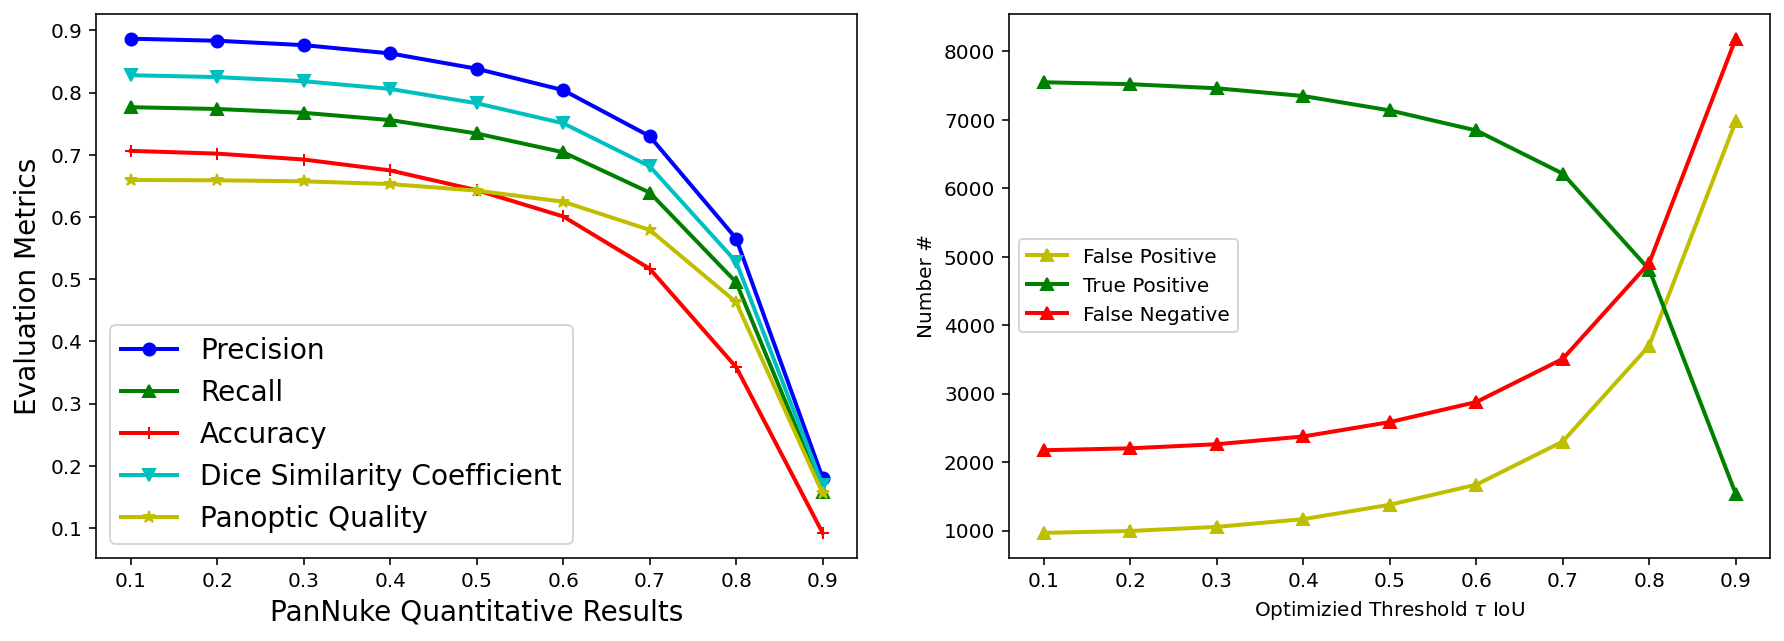

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
colors = "bgrcymkw"
markers='o^+v*'
i= 0
for m in ('precision', 'recall', 'accuracy', 'f1', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats1], '.-', lw=2, label=m,c=colors[i],marker=markers[i])
    i=i+1
ax1.set_xlabel(r'PanNuke Quantitative Results', fontsize=14)
ax1.set_ylabel('Evaluation Metrics', fontsize=14)
# t="CPM-17 Quantitative Results"
# ax1.title(t)
# ax1.grid()
ax1.legend()
L=ax1.legend( fontsize=14)
L.get_texts()[0].set_text('Precision')
L.get_texts()[1].set_text('Recall')
L.get_texts()[2].set_text('Accuracy')
L.get_texts()[3].set_text('Dice Similarity Coefficient')
L.get_texts()[4].set_text('Panoptic Quality')
colors1 = "ygrmgrcy"
j=0
for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats1], '.-', lw=2, label=m,c=colors1[j],marker='^')
    j=j+1
ax2.set_xlabel(r'Optimizied Threshold $\tau$ IoU')
ax2.set_ylabel('Number #')
# ax2.grid()
ax2.legend();
L1=ax2.legend()
L1.get_texts()[0].set_text('False Positive')
L1.get_texts()[1].set_text('True Positive')
L1.get_texts()[2].set_text('False Negative')

In [ ]:
def test_img_res( lbl, cls_dict, n_classes=5):
    c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    res = np.zeros(lbl.shape, np.uint16)

    for i in range(1,c.shape[-1]):
        m = c[...,i]>0
        res[m] = i

    print(res.shape)
    print(res)
    print(np.unique(res))

    return res

In [ ]:
from nltk import flatten
cls_val_tmp_dict = [[0 for x in range(66536)] for y in range(len(Cls_val))]
cls_val_dict = [[0 for x in range(66536)] for y in range(len(Cls_val))]
cls_tmp_val=np.zeros_like(Y_val)
for i in range(len(Cls_val)):

   cls_tmp_val[i]=test_img_res( Y_val_pred[i],    class_from_res(res_val_pred[i]));
cls=[cls[...,4]for cls in trn_data]
cls_val_new = [cls[i] for i in ind_val]
for i in range(len(Cls_val)):
    cls_val_dict[i]=cls_val_new[i].flatten()
    cls_val_tmp_dict[i]=cls_tmp_val[i].flatten()
tr=list(cls_val_tmp_dict)
tr1=flatten(tr)
z=np.concatenate( tr1, axis=0 )
tr2=list(cls_val_dict)
tr3=flatten(tr2)
w=np.concatenate( tr3, axis=0 )
z[z == 5] = 4
w[w == 5] = 4

(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1 2 3]
(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1 3]
(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1 3 5]
(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1 2 3]
(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1 2 3]
(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1 2 3 5]
(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 1 3]
(256, 256)
[[0 

In [ ]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(z,w)

print(cf_matrix)

[[21879437   335635    77258   280252   124692]
 [  311265  1333676    53026   136661   151342]
 [   46766    22569   284239    58664    45104]
 [  174212   107538    66022   582487    51625]
 [   65740    59226     8126    24286   327768]]


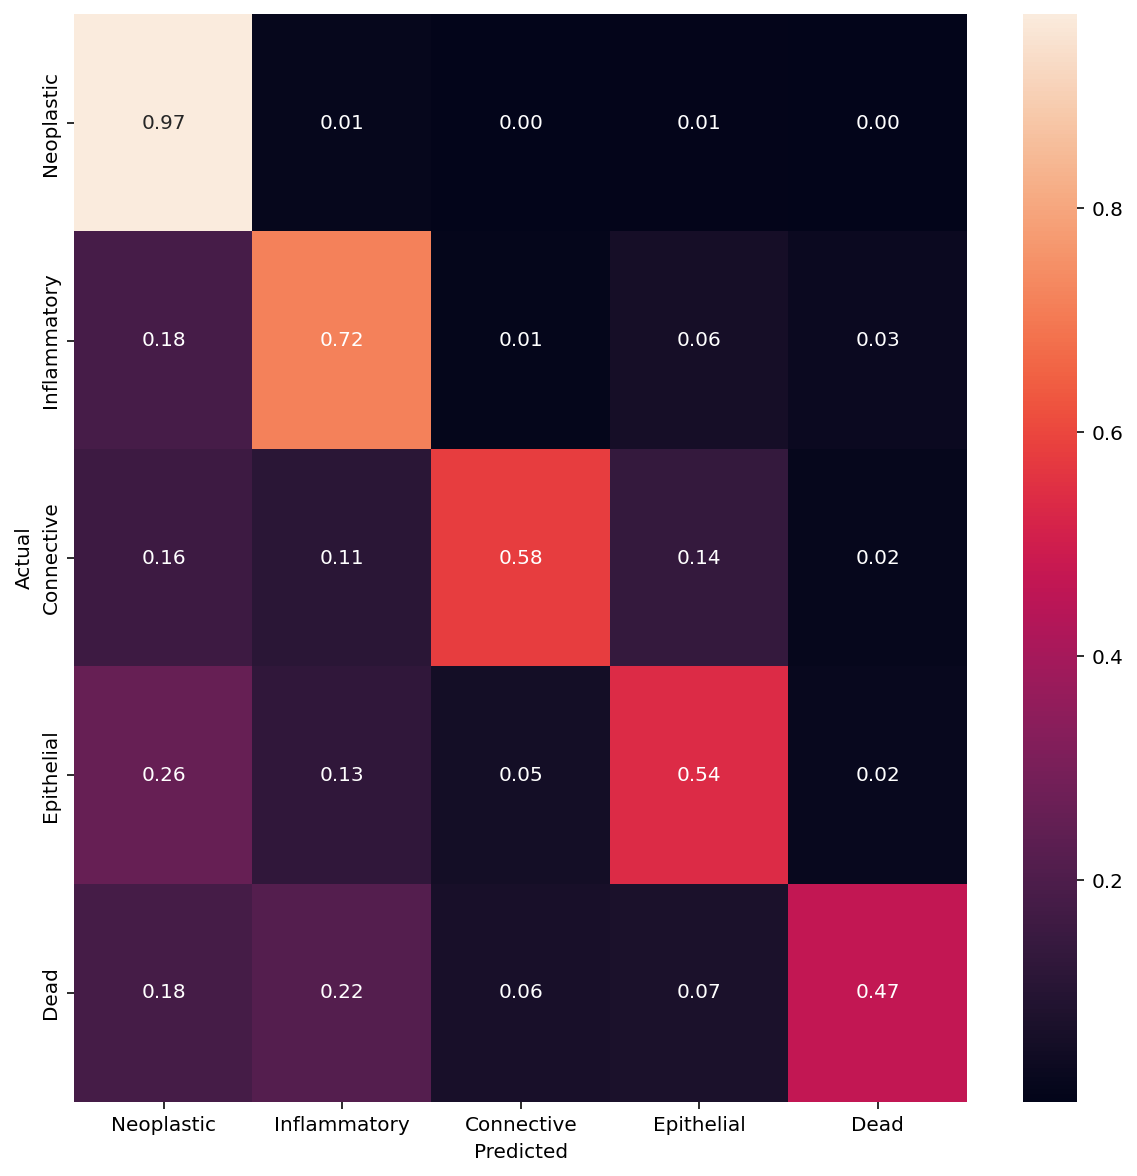

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['Neoplastic', 'Inflammatory', 'Connective','Epithelial','Dead']
cm = confusion_matrix(w, z)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
0.61, 0.46, 0.4, 0.35, 30
0.42

In [38]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
import numpy as np
from tabulate import tabulate

def classification_report(y_true, y_pred, labels=None, target_names=None,
                          sample_weight=None, digits=4, tablfmt='pipe'):
    """  Better format for sklearn's classification report
    Based on tabulate package
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.
    labels : array, shape = [n_labels]
        Optional list of label indices to include in the report.
    target_names : list of strings
        Optional display names matching the labels (same order).
    sample_weight : array-like of shape = [n_samples], optional
        Sample weights.
    digits : int
        Number of digits for formatting output floating point values
    Returns
    -------
    report : string
        Text summary of the precision, recall, F1 score for each class.
        The reported averages are a prevalence-weighted macro-average across
        classes (equivalent to :func:`precision_recall_fscore_support` with
        ``average='weighted'``).
        Note that in binary classification, recall of the positive class
        is also known as "sensitivity"; recall of the negative class is
        "specificity".
    Examples
    --------
    >>> from sklearn.metrics import classification_report
    >>> y_true = [0, 1, 2, 2, 2]
    >>> y_pred = [0, 0, 2, 2, 1]
    >>> target_names = ['class 0', 'class 1', 'class 2']
    >>> print(classification_report(y_true, y_pred, target_names=target_names))
                 precision    recall  f1-score   support
    """
    floatfmt = '.{:}f'.format(digits)
    if labels is None:
        labels = unique_labels(y_true, y_pred)
    else:
        labels = np.asarray(labels)

    if target_names is not None and len(labels) != len(target_names):
        print(
            "labels size, {0}, does not match size of target_names, {1}"
            .format(len(labels), len(target_names))
        )

    last_line_heading = 'avg / total'

    if target_names is None:
        target_names = [u'%s' % l for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None,
                                                  sample_weight=sample_weight)

    rows = zip(target_names, p, r, f1, s)
    tbl_rows = []
    for row in rows:
        tbl_rows.append(row)

    # compute averages
    last_row = (last_line_heading,
                np.average(p, weights=s),
                np.average(r, weights=s),
                np.average(f1, weights=s),
                np.sum(s))
    tbl_rows.append(last_row)
    return tabulate(tbl_rows, headers=headers,
                    tablefmt=tablfmt, floatfmt=floatfmt)

In [39]:
# from sklearn import metrics
# from yellowbrick.classifier import classification_report

print(classification_report(w,z, digits=5))

|             |   precision |   recall |   f1-score |        support |
|:------------|------------:|---------:|-----------:|---------------:|
| 0           |     0.96397 |  0.97340 |    0.96866 | 22477420.00000 |
| 1           |     0.67155 |  0.71755 |    0.69379 |  1858644.00000 |
| 2           |     0.62150 |  0.58166 |    0.60092 |   488671.00000 |
| 3           |     0.59323 |  0.53817 |    0.56436 |  1082350.00000 |
| 4           |     0.67561 |  0.46789 |    0.55288 |   700531.00000 |
| avg / total |     0.91458 |  0.91732 |    0.91531 | 26607616.00000 |


In [43]:
import pandas as pd
def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

In [44]:
print(get_classification_report(w,z))

              precision    recall  f1-score       support
0              0.963968  0.973396  0.968659  2.247742e+07
accuracy       0.917317  0.917317  0.917317  9.173166e-01
weighted avg   0.914579  0.917317  0.915312  2.660762e+07
1              0.671549  0.717553  0.693789  1.858644e+06
macro avg      0.705172  0.655732  0.676122  2.660762e+07
2              0.621502  0.581657  0.600920  4.886710e+05
3              0.593234  0.538169  0.564361  1.082350e+06
4              0.675607  0.467885  0.552879  7.005310e+05


In [45]:
report=get_classification_report(w,z)

In [48]:
report['f1-score']*0.64

0               0.619942
accuracy        0.587083
weighted avg    0.585799
1               0.444025
macro avg       0.432718
2               0.384589
3               0.361191
4               0.353843
Name: f1-score, dtype: float64

In [ ]:
0.20, 0.317, 0.347, 0.43, 0.62

In [ ]:
def get_multi_pq_info(true, pred, true_in, pred_in , nr_classes=6, match_iou=0.5):


    assert match_iou >= 0.0, "Cant' be negative"

    true_inst = true_in
    pred_inst = pred_in
    ###
    true_class = true
    pred_class = pred

    pq = []
    for idx in range(nr_classes):
        pred_class_tmp = pred_class == idx + 1
        print(pred_class_tmp)
        pred_inst_oneclass = pred_inst * pred_class_tmp
        print(pred_inst_oneclass)
        pred_inst_oneclass = remap_label(pred_inst_oneclass)
        ##
        true_class_tmp = true_class == idx + 1
        true_inst_oneclass = true_inst * true_class_tmp
        true_inst_oneclass = remap_label(true_inst_oneclass)

        pq_oneclass_info = get_pq(true_inst_oneclass, pred_inst_oneclass, remap=False)

        # add (in this order) tp, fp, fn iou_sum
        pq_oneclass_stats = [
            pq_oneclass_info[1][0],
            pq_oneclass_info[1][1],
            pq_oneclass_info[1][2],
            pq_oneclass_info[2],
        ]
        pq.append(pq_oneclass_stats)

    return pq


In [ ]:


import numpy as np
import pathlib
import os
import shutil


def remap_label(pred, by_size=False):
    """Rename all instance id so that the id is contiguous i.e [0, 1, 2, 3] 
    not [0, 2, 4, 6]. The ordering of instances (which one comes first) 
    is preserved unless by_size=True, then the instances will be reordered
    so that bigger nucler has smaller ID.
    Args:
        pred (ndarray): the 2d array contain instances where each instances is marked
            by non-zero integer.
        by_size (bool): renaming such that larger nuclei have a smaller id (on-top).
    Returns:
        new_pred (ndarray): Array with continguous ordering of instances.
    """
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred


def cropping_center(x, crop_shape, batch=False):
    """Crop an array at the centre with specified dimensions."""
    orig_shape = x.shape
    if not batch:
        h0 = int((orig_shape[0] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[1] - crop_shape[1]) * 0.5)
        x = x[h0 : h0 + crop_shape[0], w0 : w0 + crop_shape[1]]
    else:
        h0 = int((orig_shape[1] - crop_shape[0]) * 0.5)
        w0 = int((orig_shape[2] - crop_shape[1]) * 0.5)
        x = x[:, h0 : h0 + crop_shape[0], w0 : w0 + crop_shape[1]]
    return x


def rm_n_mkdir(dir_path):
    """Remove and make directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)


def rmdir(dir_path):
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    return


def recur_find_ext(root_dir, ext_list):
    """Recursively find all files in directories end with the `ext` such as `ext='.png'`.
    Args:
        root_dir (str): Root directory to grab filepaths from.
        ext_list (list): File extensions to consider.
    Returns:
        file_path_list (list): sorted list of filepaths.
    """
    file_path_list = []
    for cur_path, dir_list, file_list in os.walk(root_dir):
        for file_name in file_list:
            file_ext = pathlib.Path(file_name).suffix
            if file_ext in ext_list:
                full_path = os.path.join(cur_path, file_name)
                file_path_list.append(full_path)
    file_path_list.sort()
    return file_path_list


def rm_n_mkdir(dir_path):
    """Remove and then make a new directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)


def get_bounding_box(img):
    """Get the bounding box coordinates of a binary input- assumes a single object.
    Args:
        img: input binary image.
    Returns:
        bounding box coordinates
    """
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    # due to python indexing, need to add 1 to max
    # else accessing will be 1px in the box, not out
    rmax += 1
    cmax += 1
    return [rmin, rmax, cmin, cmax]


In [ ]:
def get_pq(true, pred, match_iou=0.5, remap=True):

    assert match_iou >= 0.0, "Cant' be negative"
    # ensure instance maps are contiguous
    if remap:
        pred = remap_label(pred)
        true = remap_label(true)

    true = np.copy(true)
    pred = np.copy(pred)
    true = true.astype("int32")
    pred = pred.astype("int32")
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))
    # prefill with value
    pairwise_iou = np.zeros([len(true_id_list), len(pred_id_list)], dtype=np.float64)

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask_lab = true == true_id
        rmin1, rmax1, cmin1, cmax1 = get_bounding_box(t_mask_lab)
        t_mask_crop = t_mask_lab[rmin1:rmax1, cmin1:cmax1]
        t_mask_crop = t_mask_crop.astype("int")
        p_mask_crop = pred[rmin1:rmax1, cmin1:cmax1]
        pred_true_overlap = p_mask_crop[t_mask_crop > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask_lab = pred == pred_id
            p_mask_lab = p_mask_lab.astype("int")

            # crop region to speed up computation
            rmin2, rmax2, cmin2, cmax2 = get_bounding_box(p_mask_lab)
            rmin = min(rmin1, rmin2)
            rmax = max(rmax1, rmax2)
            cmin = min(cmin1, cmin2)
            cmax = max(cmax1, cmax2)
            t_mask_crop2 = t_mask_lab[rmin:rmax, cmin:cmax]
            p_mask_crop2 = p_mask_lab[rmin:rmax, cmin:cmax]

            total = (t_mask_crop2 + p_mask_crop2).sum()
            inter = (t_mask_crop2 * p_mask_crop2).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou

    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / ((tp + 0.5 * fp + 0.5 * fn) + 1.0e-6)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return (
        [dq, sq, dq * sq],
        [tp, fp, fn],
        paired_iou.sum(),
    )


def get_multi_r2(true, pred):
    """Get the correlation of determination for each class and then 
    average the results.
    
    Args:
        true (pd.DataFrame): dataframe indicating the nuclei counts for each image and category.
        pred (pd.DataFrame): dataframe indicating the nuclei counts for each image and category.
    
    Returns:
        multi class coefficient of determination
        
    """
    # first check to make sure that the appropriate column headers are there
    class_names = [
        "epithelial",
        "lymphocyte",
        "plasma",
        "neutrophil",
        "eosinophil",
        "connective",
    ]
    for col in true.columns:
        if col not in class_names:
            raise ValueError("%s column header not recognised")

    for col in pred.columns:
        if col not in class_names:
            raise ValueError("%s column header not recognised")

    # for each class, calculate r2 and then take the average
    r2_list = []
    for class_ in class_names:
        true_oneclass = true[class_].tolist()
        pred_oneclass = pred[class_].tolist()
        r2_list.append(r2_score(true_oneclass, pred_oneclass))

    return np.mean(np.array(r2_list))

In [ ]:
from docopt import docopt
import numpy as np
import os
import pandas as pd
from tqdm.auto import tqdm




# initialise empty placeholder lists
pq_list = []
mpq_info_list = []
        # load the prediction and ground truth arrays
pred_array = np.array(cls_tmp_val)
true_array = np.array(cls_val_new)
nr_patches = pred_array.shape[0]
print(nr_patches)
pred_array1 = np.array(Y_val_pred)
true_array1 = np.array(Y_val)
nr_patches = pred_array.shape[0]
print(nr_patches)

406
406


In [ ]:
for patch_idx in tqdm(range(nr_patches)):
            # get a single patch
            pred = pred_array[patch_idx]
            true = true_array[patch_idx]

            # instance segmentation map
            pred_inst = pred_array1
            true_inst = true_array1
            # classification map
            pred_class = pred_array
            true_class = true_array


  0%|          | 0/406 [00:00<?, ?it/s]

In [ ]:
mpq_info_single = get_multi_pq_info(pred_class, true_class, pred_inst, true_inst)
mpq_info = []
# aggregate the stat info per class
for single_class_pq in mpq_info_single:
    tp = single_class_pq[0]
    fp = single_class_pq[1]
    fn = single_class_pq[2]
    sum_iou = single_class_pq[3]
    mpq_info.append([tp, fp, fn, sum_iou])
mpq_info_list.append(mpq_info)

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

In [ ]:
print(mpq_info_list)

[[[0, 126, 113, 0.0], [8, 152, 102, 6.308768670989533], [0, 102, 63, 0.0], [0, 64, 0, 0.0], [0, 65, 60, 0.0]]]


In [ ]:


from docopt import docopt
import numpy as np
import os
import pandas as pd
from tqdm.auto import tqdm




# initialise empty placeholder lists
pq_list = []
mpq_info_list = []
        # load the prediction and ground truth arrays
# pred_array = np.load(cls_tmp_val)
# true_array = np.load(cls_val_new)

nr_patches = pred_array.shape[0]

for patch_idx in tqdm(range(nr_patches)):
            pred = pred_array[patch_idx]
            true = true_array[patch_idx]

            # instance segmentation map
            pred_inst = pred_array1
            true_inst = true_array1
            # classification map
            pred_class = pred_array
            true_class = true_array

            # ===============================================================

            # get the multiclass pq stats info from single image
            mpq_info_single = get_multi_pq_info(pred_class, true_class, pred_inst, true_inst)
            mpq_info = []
                    # aggregate the stat info per class
            for single_class_pq in mpq_info_single:
                         tp = single_class_pq[0]
                         fp = single_class_pq[1]
                         fn = single_class_pq[2]
                         sum_iou = single_class_pq[3]
                         mpq_info.append([tp, fp, fn, sum_iou])
            mpq_info_list.append(mpq_info)
            pq_metrics = np.array(pq_list)
            pq_metrics_avg = np.mean(pq_metrics, axis=-1)  # average over all images
            mpq_info_metrics = np.array(mpq_info_list, dtype="float")
            # sum over all the images
            total_mpq_info_metrics = np.sum(mpq_info_metrics, axis=0)
            mpq_list = []
            # for each class, get the multiclass PQ
            for cat_idx in range(total_mpq_info_metrics.shape[0]):
                       total_tp = total_mpq_info_metrics[cat_idx][0]
                       total_fp = total_mpq_info_metrics[cat_idx][1]
                       total_fn = total_mpq_info_metrics[cat_idx][2]
                       total_sum_iou = total_mpq_info_metrics[cat_idx][3]

                        # get the F1-score i.e DQ
            dq = total_tp / (
                        (total_tp + 0.5 * total_fp + 0.5 * total_fn) + 1.0e-6
                    )
                    # get the SQ, when not paired, it has 0 IoU so does not impact
            sq = total_sum_iou / (total_tp + 1.0e-6)
            mpq_list.append(dq * sq)
            mpq_metrics = np.array(mpq_list)
            all_metrics[metric] = [np.mean(mpq_metrics)]
            all_metrics[metric] = [pq_metrics_avg]
            df = pd.DataFrame(all_metrics)
            df = df.to_string(index=False)
            print(df)

  0%|          | 0/406 [00:00<?, ?it/s]

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

fromnumeric.py (3441): Mean of empty slice.
_methods.py (189): invalid value encountered in double_scalars


NameError: ignored

In [ ]:
print(total_fn)


60.0
